This notebook is an experiment for trying out predicting facial landmarks on [Facial Landmarks Dataset](https://www.kaggle.com/drgilermo/face-images-with-marked-landmark-points) from kaggle

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('data')
path.ls()

[PosixPath('data/face_images'),
 PosixPath('data/face_images.npz'),
 PosixPath('data/models'),
 PosixPath('data/face-images-with-marked-landmark-points.zip'),
 PosixPath('data/new-gray.png'),
 PosixPath('data/facial_keypoints.csv'),
 PosixPath('data/new.jpg'),
 PosixPath('data/face_images.pth'),
 PosixPath('data/imgs'),
 PosixPath('data/test.jpg'),
 PosixPath('data/test-gray.png')]

The dataset is in numpy arrays(.npz) format. Lets prepare the dataset to be loaded into the fastai library. 

In [6]:
def convertToTensor(path, filename, key):
    images = np.load(str(path/filename)+'.npz')['face_images']
    images = torch.from_numpy(images).permute(2,0,1)
    for i in range(images.shape[0]):
        plt.imsave(path/'imgs'/f'{i}.png', images[i],cmap='gray')
    torch.save(images, str(path/filename)+'.pth')

In [7]:
convertToTensor(path, 'face_images', 'face_images')

In [8]:
path_imgs = path/'imgs'

In [9]:
keypoints = pd.read_csv(path/'facial_keypoints.csv').reset_index()
keypoints.dropna(inplace=True)
keypoints['index']=keypoints['index'].apply(lambda x: str(x)+'.png')

In [10]:
cols = list(keypoints.columns[1:])

Getting label for a single example

In [14]:
def get_points(f):
    f = Path(f)
    data = keypoints[keypoints['index'] == f.name].iloc[:,1:]
    return torch.from_numpy(data.values).view(15,2).flip(1,0)

In [15]:
get_points('0.png')

tensor([[84.4858, 43.1307],
        [72.9355, 43.3126],
        [77.3890, 28.6145],
        [79.9702, 61.1953],
        [57.0668, 44.4206],
        [29.6475, 16.3564],
        [29.0023, 40.2276],
        [32.2281, 80.2271],
        [29.0336, 56.9533],
        [37.3894, 23.4529],
        [37.3894, 36.3566],
        [39.9700, 73.1303],
        [39.6474, 59.5821],
        [36.4217, 30.2270],
        [39.0023, 66.0336]], dtype=torch.float64)

Using datablock api to load, split and label the data. The data is then normalized with the imagenet stats.

In [18]:
src = (PointsItemList.from_df(keypoints, path,cols=['index'],folder='imgs')
        .split_by_rand_pct()
        .label_from_func(get_points))

In [19]:
data = (src.transform(size=96)
        .databunch(bs=64)
       .normalize(imagenet_stats))

Lets have a look at a batch of data to see if the data is loaded correctly. We can see that the landmarks align with the images. So we can proceed with training a model on the data.

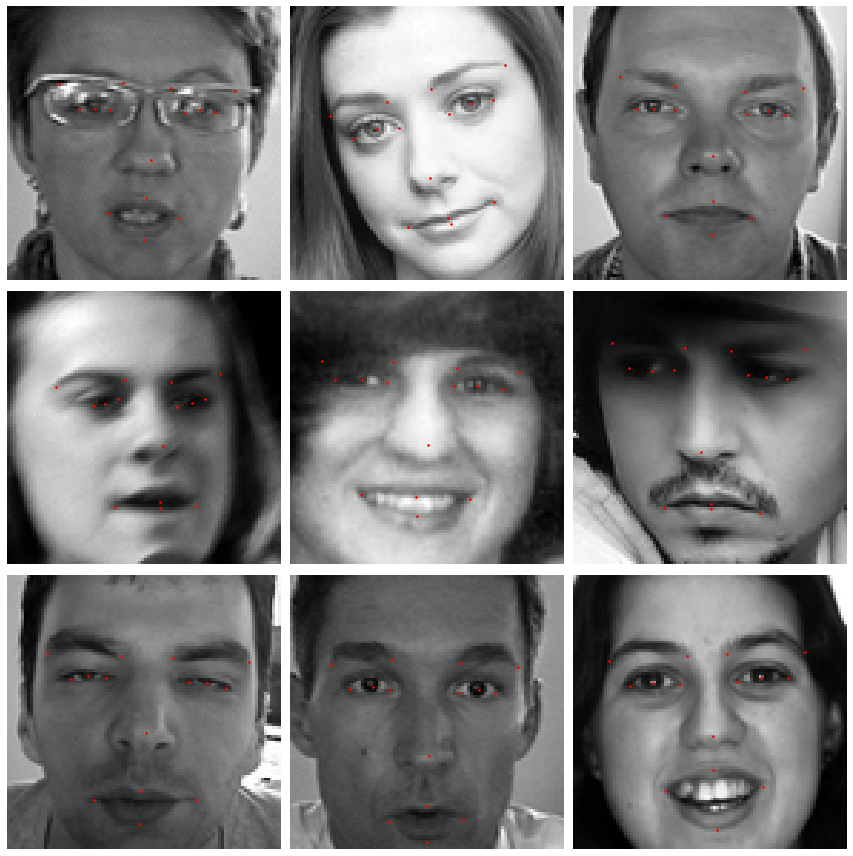

In [21]:
data.show_batch(3)

# Learner with resnet34

In [23]:
learn = cnn_learner(data, models.resnet34).to_fp16()

epoch,train_loss,valid_loss,time
0,4.278706,#na#,00:09
1,4.130299,#na#,00:07
2,2.985742,#na#,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


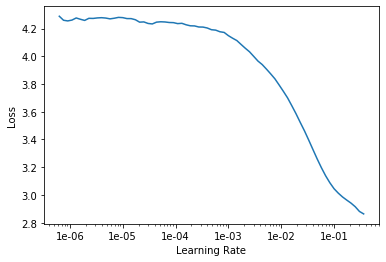

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr = 1e-2

In [26]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,3.397665,1.390674,00:09
1,2.210907,0.348403,00:08
2,1.247500,0.056729,00:08
3,0.703916,0.016205,00:08
4,0.407031,0.008932,00:09
5,0.240112,0.007642,00:09
6,0.143823,0.004732,00:08
7,0.087518,0.004586,00:08
8,0.054253,0.004232,00:08
9,0.034613,0.004114,00:08


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1712 items)
x: PointsItemList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: PointsLabelList
ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96)
Path: data;

Valid: LabelList (428 items)
x: PointsItemList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: PointsLabelList
ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96),ImagePoints (96, 96)
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_si

In [29]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.006336,#na#,00:12
1,0.006421,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


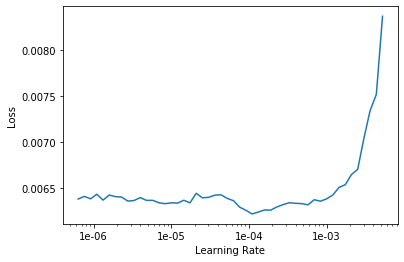

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,time
0,0.006479,0.003963,00:13
1,0.006208,0.004561,00:13
2,0.006756,0.005716,00:13
3,0.007047,0.004743,00:14
4,0.006756,0.003772,00:13
5,0.006181,0.003194,00:13
6,0.005306,0.002774,00:14
7,0.004545,0.002505,00:13
8,0.003908,0.002418,00:13
9,0.003471,0.002369,00:13


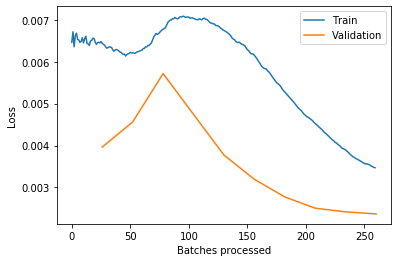

In [32]:
learn.recorder.plot_losses()

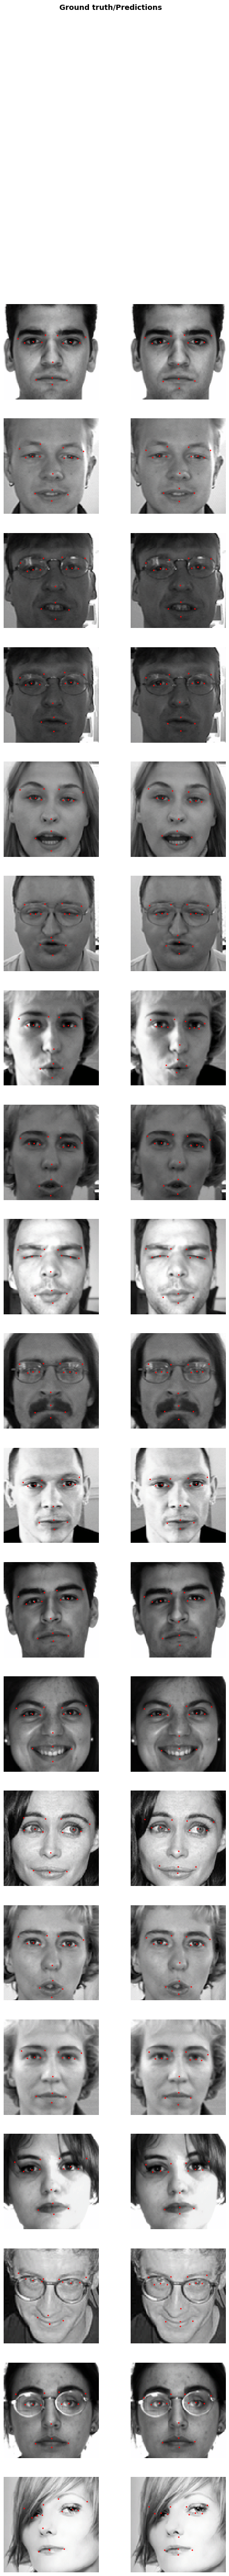

In [33]:
learn.show_results(DatasetType.Valid,20)